**En este notebook vemos como hacer `agrupaciones manuales` de manera interactiva.<br>
También comentamos como se manejan internamente los `missings`.**

<span style='color:blue'>Importamos los módulos

In [1]:
import sys, numpy as np, pandas as pd, memento as me

<span style='color:blue'>Cargamos los datos

In [2]:
data = pd.read_csv('stroke_data.csv')
X, y = data.drop('stroke', axis=1), data['stroke']
print('El dataset tiene {} filas y {} columnas'.format(X.shape[0], X.shape[1]))

El dataset tiene 5110 filas y 11 columnas


<span style='color:blue'>La variable numérica `bmi` es la única que tiene missings

In [3]:
X.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
dtype: int64

<span style='color:blue'>Metemos missings también la variable de texto `work_type` quitando el valor `Self-employed`

In [4]:
X['work_type'] = X['work_type'].replace('Self-employed', np.nan)
X.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type            819
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
dtype: int64

<span style='color:blue'>Sacamos el modelo automático excluyendo la variable `id` por motivos evidentes

In [5]:
modelo1 = me.Scorecard(excluded_vars=['id']).fit(X, y)
# modelo1 = me.Scorecard(id_columns=['id']).fit(X, y) # Da el mismo resultado pero así además guarda 'id' en los datas

Particionado 70-30 estratificado en el target terminado
------------------------------------------------------------------------------------------------------------------------
Autogrouping terminado. Máximo número de buckets = 5. Mínimo porcentaje por bucket = 0.05
------------------------------------------------------------------------------------------------------------------------
Cuidado, has puesto un valor numero máximo de iteraciones (14) superior al número de variables candidatas (9)
------------------------------------------------------------------------------------------------------------------------
Step 01 | 0:00:00.076140 | pv = 1.89e-36 | Gini train = 64.73% | Gini test = 66.78% ---> Feature selected: age
Step 02 | 0:00:00.131523 | pv = 5.95e-11 | Gini train = 70.88% | Gini test = 67.94% ---> Feature selected: bmi
Step 03 | 0:00:00.145748 | pv = 1.58e-05 | Gini train = 72.59% | Gini test = 68.10% ---> Feature selected: avg_glucose_level
----------------------------------

**<span style='color:red'>¿Y si no quiero usar las agrupaciones del autogrouping? ¿Y si quiero modificarlas o directamente usar las que a mí me de la gana?**
<span style='color:blue'> Hay 2 funciones que nos permiten hacer esto
- La función `reagrupa_var`, que nos permite variable a variable reagrupar metiendo a mano los nuevos grupos
- La función `interfaz_grafica` que nos permite en un set de variable hacer regrupaciones con una interfaz gráfica

<span style='color:red'> Empezamos explorando la primera vía: **reagrupa_var**

<span style='color:blue'>Antes de nada hay que recrear el X_train y el y_train que se usaron en el modelo y también generar los autogroupings asociados a esa partición

In [6]:
X_train, y_train = me.split(X, y)[0:3:2]
autogroupings = me.autogrouping(X_train, y_train)[0]

<span style='color:blue'>Para usar `reagrupar_var` hay que decirle que variable queremos tocar, si no especificamos una nueva agrupación nos mostrará la de los autogroupings

,Group,Count,Percent,Goods,Bads,Bad rate,WoE,IV
0,"(-inf, 48.50)",1996,0.558010,1984,12,0.006012,2.134606,1.097293
1,"[48.50, 56.50)",454,0.126922,434,20,0.044053,0.103955,0.001309
2,"[56.50, 67.50)",535,0.149567,496,39,0.072897,-0.430343,0.033732
3,"[67.50, 75.50)",278,0.077719,238,40,0.143885,-1.189966,0.190331
4,"[75.50, inf)",314,0.087783,251,63,0.200637,-1.591039,0.458713
Totals,,3577,1.000000,3403,174,0.048644,,1.781379


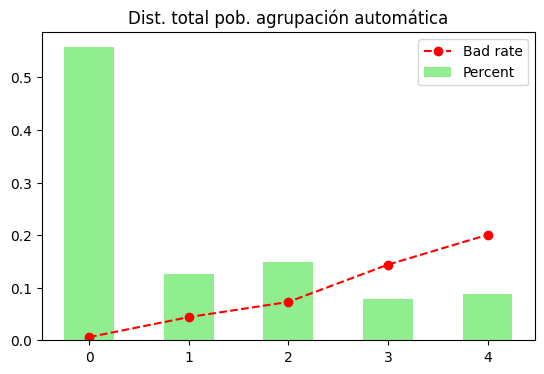

----------------------------------------------------------------------------------------------------
Agrupación automática: {'bp': [48.5, 56.5, 67.5, 75.5], 'mg': None}
----------------------------------------------------------------------------------------------------


In [7]:
me.reagrupa_var(X_train, y_train, autogroupings, 'age', dims=(14, 4))

<span style='color:blue'>Probamos a pasarle una nueva agrupación con solo 3 grupos

,Group,Count,Percent,Goods,Bads,Bad rate,WoE,IV
0,"(-inf, 48.50)",1996,0.558010,1984,12,0.006012,2.134606,1.097293
1,"[48.50, 56.50)",454,0.126922,434,20,0.044053,0.103955,0.001309
2,"[56.50, 67.50)",535,0.149567,496,39,0.072897,-0.430343,0.033732
3,"[67.50, 75.50)",278,0.077719,238,40,0.143885,-1.189966,0.190331
4,"[75.50, inf)",314,0.087783,251,63,0.200637,-1.591039,0.458713
Totals,,3577,1.000000,3403,174,0.048644,,1.781379
,Group,Count,Percent,Goods,Bads,Bad rate,WoE,IV
0,"(-inf, 30.00)",1077,0.301090,1075,2,0.001857,3.313571,1.008663
1,"[30.00, 60.00)",1538,0.429969,1494,44,0.028609,0.551665,0.102693
2,"[60.00, inf)",962,0.268940,834,128,0.133056,-1.099154,0.539195


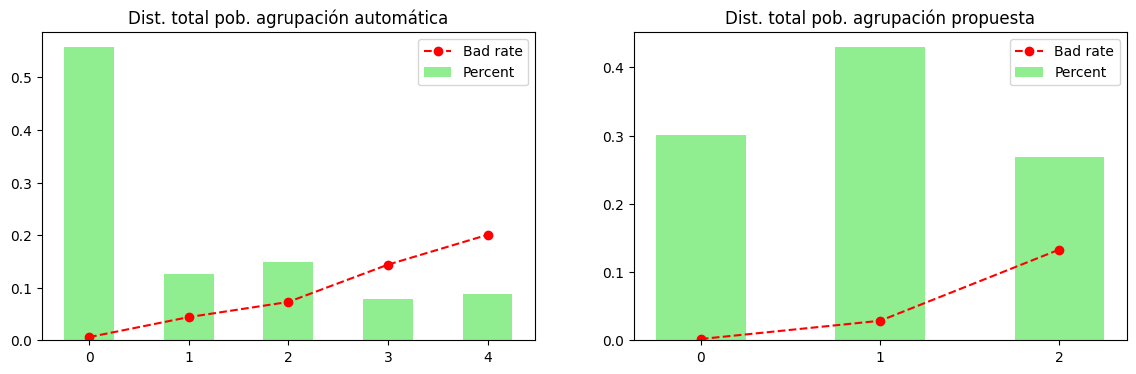

----------------------------------------------------------------------------------------------------
Agrupación automática: {'bp': [48.5, 56.5, 67.5, 75.5], 'mg': None}
----------------------------------------------------------------------------------------------------
Agrupación final propuesta: [30, 60]
----------------------------------------------------------------------------------------------------


In [8]:
me.reagrupa_var(X_train, y_train, autogroupings, 'age', [30, 60], dims=(14, 4))

<span style='color:blue'>Entonces para usar esta nueva agrupación de la variable `age` lanzamos de nuevo una scorecard con la agrupación en el diccionario `user_breakpoints`

In [9]:
modelo2 = me.Scorecard(excluded_vars=['id'], user_breakpoints={'age': [30, 60]}).fit(X, y)

Particionado 70-30 estratificado en el target terminado
------------------------------------------------------------------------------------------------------------------------
Autogrouping terminado. Máximo número de buckets = 5. Mínimo porcentaje por bucket = 0.05
------------------------------------------------------------------------------------------------------------------------
Cuidado, has puesto un valor numero máximo de iteraciones (14) superior al número de variables candidatas (9)
------------------------------------------------------------------------------------------------------------------------
Step 01 | 0:00:00.082780 | pv = 8.28e-27 | Gini train = 56.54% | Gini test = 54.72% ---> Feature selected: age
Step 02 | 0:00:00.128340 | pv = 1.99e-10 | Gini train = 64.46% | Gini test = 58.66% ---> Feature selected: bmi
Step 03 | 0:00:00.147151 | pv = 1.01e-06 | Gini train = 67.69% | Gini test = 60.01% ---> Feature selected: avg_glucose_level
Step 04 | 0:00:00.153648 | pv = 7.

<span style='color:blue'>**Observación**: Ahora está entrando también la variable `hypertension`, cosa que antes no pasaba... Esto ocurre porque la nueva agrupación de `age` hace que esta variable sea aparentemente menos discriminante: ahora en el primer paso el modelo tiene un 56.54% de gini en train cuando antes, con la agrupación automática, en el primer paso el modelo tenía un 64.73%. Por este motivo ahora al final el método de selección de variables acaba escogiendo también a `hypertension`. Si se quiere evitar esto se puede introducir las variables exactas que queremos que formen parte de la scorecard en el parámetro `features` y así comparar mejor el impacto de la nueva agrupación.

In [10]:
modelo3 = me.Scorecard(
    features=['age', 'bmi', 'avg_glucose_level'],
    user_breakpoints={'age': [30, 60]}
).fit(X, y)

Particionado 70-30 estratificado en el target terminado
------------------------------------------------------------------------------------------------------------------------
Autogrouping terminado. Máximo número de buckets = 5. Mínimo porcentaje por bucket = 0.05
------------------------------------------------------------------------------------------------------------------------
Step 01 | 0:00:00.000000 | pv = 8.28e-27 | Gini train = 56.54% | Gini test = 54.72% ---> Feature selected: age
Step 02 | 0:00:00.000000 | pv = 1.99e-10 | Gini train = 64.46% | Gini test = 58.66% ---> Feature selected: bmi
Step 03 | 0:00:00.000000 | pv = 1.01e-06 | Gini train = 67.69% | Gini test = 60.01% ---> Feature selected: avg_glucose_level
------------------------------------------------------------------------------------------------------------------------
Selección terminada: ['age', 'bmi', 'avg_glucose_level']
---------------------------------------------------------------------------------------

<span style='color:blue'>Vemos como estaría quedando la scorecard

In [11]:
me.pretty_scorecard(modelo3, 'pink')

,Variable,Group,Count,Percent,Goods,Bads,Bad rate,WoE,IV,Raw score,Aligned score
0,age,"(-inf, 30.00)",1077,0.301090,1075,2,0.001857,3.313571,1.008663,-2.949666,281
1,age,"[30.00, 60.00)",1538,0.429969,1494,44,0.028609,0.551665,0.102693,-0.491080,210
2,age,"[60.00, inf)",962,0.268940,834,128,0.133056,-1.099154,0.539195,0.978442,167
3,bmi,Missing,147,0.041096,118,29,0.197279,-1.569969,0.207222,1.111950,163
4,bmi,"(-inf, 23.75)",910,0.254403,893,17,0.018681,0.988016,0.162740,-0.699775,216
5,bmi,"[23.75, 30.75)",1306,0.365110,1239,67,0.051302,-0.055990,0.001174,0.039656,194
6,bmi,"[30.75, 32.05)",199,0.055633,181,18,0.090452,-0.665232,0.033435,0.471159,182
7,bmi,"[32.05, 36.45)",501,0.140062,489,12,0.023952,0.734098,0.054860,-0.519935,211
8,bmi,"[36.45, inf)",514,0.143696,483,31,0.060311,-0.227328,0.008235,0.161008,191
9,avg_glucose_level,"(-inf, 72.72)",645,0.180319,624,21,0.032558,0.418271,0.026216,-0.225926,202


<span style='color:blue'>También podemos usar la funcion `reagrupa_var` para comparar contra agrupaciones que no necesariamente sean las automáticas (se pondrá de otro color, por defecto en aquamarine) <br>
Contra la que queremos comparar hay que ponerla después (va en el parámetro compare_bp y la que queremos probar debe ir antes (va en el parámetro user_bp)

,Group,Count,Percent,Goods,Bads,Bad rate,WoE,IV
0,"(-inf, 30.00)",1077,0.301090,1075,2,0.001857,3.313571,1.008663
1,"[30.00, 60.00)",1538,0.429969,1494,44,0.028609,0.551665,0.102693
2,"[60.00, inf)",962,0.268940,834,128,0.133056,-1.099154,0.539195
Totals,,3577,1.000000,3403,174,0.048644,,1.650550
,Group,Count,Percent,Goods,Bads,Bad rate,WoE,IV
0,"(-inf, 40.00)",1533,0.428571,1527,6,0.003914,2.565943,1.062914
1,"[40.00, inf)",2044,0.571429,1876,168,0.082192,-0.560424,0.232150
Totals,,3577,1.000000,3403,174,0.048644,,1.295063


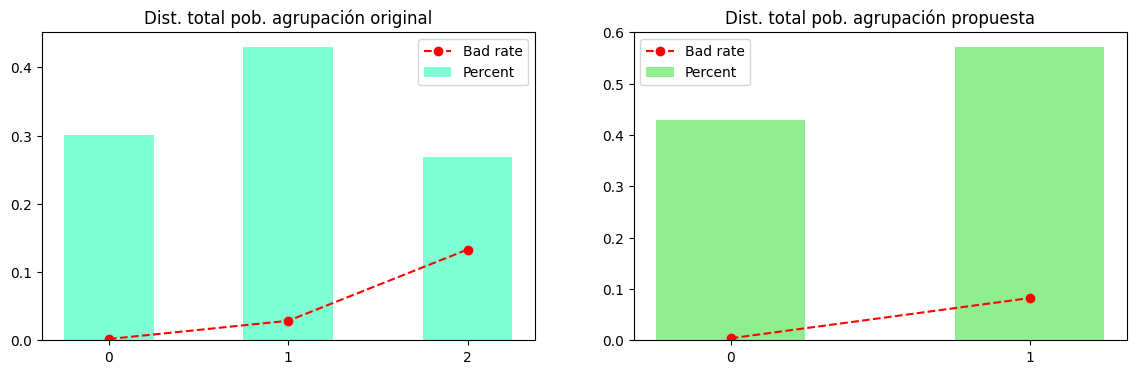

----------------------------------------------------------------------------------------------------
Agrupación original: [30, 60]
----------------------------------------------------------------------------------------------------
Agrupación final propuesta: [40]
----------------------------------------------------------------------------------------------------


In [12]:
me.reagrupa_var(X_train, y_train, autogroupings, 'age', [40], [30, 60], dims=(14, 4))

<span style='color:blue'>Vemos que en el modelo de antes también entró una de las dos variables con missings: el `bmi`. De hecho, ha puesto en un grupo a parte a estos missings y esto no es casualidad:<br>
- En el autogrouping de una variable numérica con missings **siempre se le dará un grupo aparte a estos missings**. Siempre y cuando haya al menos un malo y un bueno, independientemente de su volumen (si te fijas en este caso ese grupo ni si quiera llega al 5% mínimo que se suele exigir, da igual). Esto se hace con una asignación inicial de los missings al valor -12345678, que entendemos va a ser el mínimo de esa variable de forma que con un corte inmediatamente posterior nos garantizamos que estos missing están en un grupo aparte.

<span style='color:blue'>Ok, pero... Y si quiero juntar esos missings con otro grupo... ¿Cómo lo hago?<br>
- Se pasa un diccionario indicando por un lado los puntos de corte (pudiendo ser los mismos del autogrouping o no) **eliminando de ellos el valor -12345670** y por otro lado indicando a qué grupo (nº grupo >= 1) se desea mandar los missings 


<span style='color:blue'>Probamos a juntar los missings con el grupo 1

,Group,Count,Percent,Goods,Bads,Bad rate,WoE,IV
0,Missing,147,0.041096,118,29,0.197279,-1.569969,0.207222
1,"(-inf, 23.75)",910,0.254403,893,17,0.018681,0.988016,0.162740
2,"[23.75, 30.75)",1306,0.365110,1239,67,0.051302,-0.05599,0.001174
3,"[30.75, 32.05)",199,0.055633,181,18,0.090452,-0.665232,0.033435
4,"[32.05, 36.45)",501,0.140062,489,12,0.023952,0.734098,0.054860
5,"[36.45, inf)",514,0.143696,483,31,0.060311,-0.227328,0.008235
Totals,,3577,1.000000,3403,174,0.048644,,0.467667
,Group,Count,Percent,Goods,Bads,Bad rate,WoE,IV
0,"(-inf, 23.75), Missing",1057,0.295499,1011,46,0.043519,0.116696,0.003819
1,"[23.75, 30.75)",1306,0.365110,1239,67,0.051302,-0.05599,0.001174


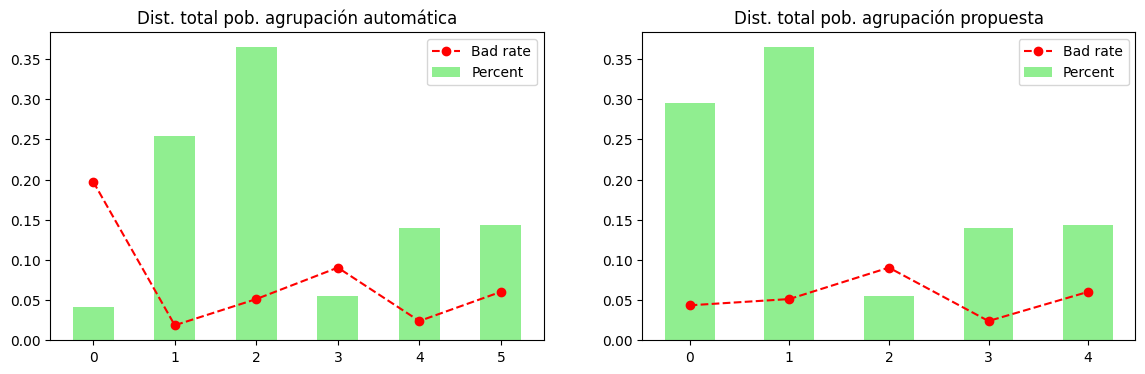

----------------------------------------------------------------------------------------------------
Agrupación automática: {'bp': [-12345670.0, 23.75, 30.75, 32.05, 36.45], 'mg': 0}
----------------------------------------------------------------------------------------------------
Agrupación final propuesta: {'bp': [23.75, 30.75, 32.05, 36.45], 'mg': 1}
----------------------------------------------------------------------------------------------------


In [13]:
me.reagrupa_var(X_train, y_train, autogroupings, 'bmi', {'bp': [23.75, 30.75, 32.05, 36.45], 'mg': 1}, dims=(14, 4))

<span style='color:blue'>Ahora pongo los missings con el último grupo tras reagrupar

,Group,Count,Percent,Goods,Bads,Bad rate,WoE,IV
0,Missing,147,0.041096,118,29,0.197279,-1.569969,0.207222
1,"(-inf, 23.75)",910,0.254403,893,17,0.018681,0.988016,0.162740
2,"[23.75, 30.75)",1306,0.365110,1239,67,0.051302,-0.05599,0.001174
3,"[30.75, 32.05)",199,0.055633,181,18,0.090452,-0.665232,0.033435
4,"[32.05, 36.45)",501,0.140062,489,12,0.023952,0.734098,0.054860
5,"[36.45, inf)",514,0.143696,483,31,0.060311,-0.227328,0.008235
Totals,,3577,1.000000,3403,174,0.048644,,0.467667
,Group,Count,Percent,Goods,Bads,Bad rate,WoE,IV
0,"(-inf, 25.00)",1119,0.312832,1094,25,0.022341,0.805363,0.143196
1,"[25.00, 30.00)",966,0.270059,912,54,0.055901,-0.146701,0.006212


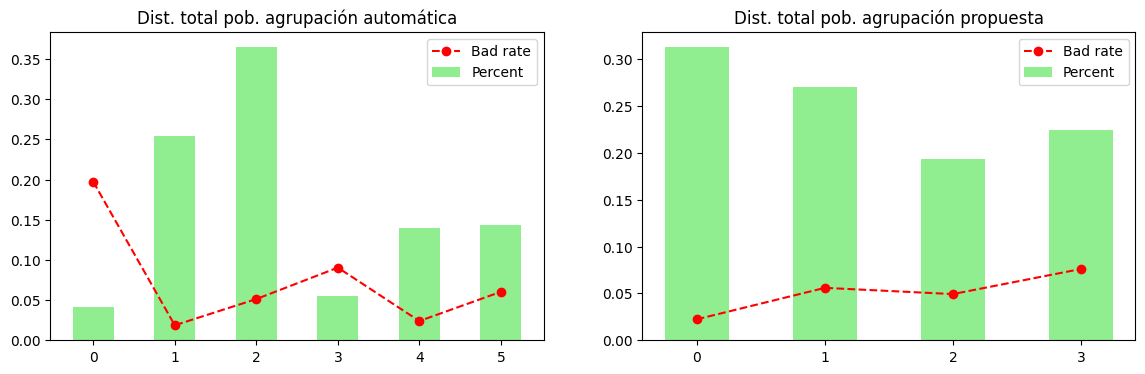

----------------------------------------------------------------------------------------------------
Agrupación automática: {'bp': [-12345670.0, 23.75, 30.75, 32.05, 36.45], 'mg': 0}
----------------------------------------------------------------------------------------------------
Agrupación final propuesta: {'bp': [25, 30, 35], 'mg': 4}
----------------------------------------------------------------------------------------------------


In [14]:
me.reagrupa_var(X_train, y_train, autogroupings, 'bmi', {'bp': [25, 30, 35], 'mg': 4}, dims=(14, 4))

<span style='color:blue'>Por último si queremos reagrupar pero manteniendo el missing en un grupo a parte debemos **volver a meter el -12345670 en la lista** y un 0 o un None en `mg`
(también se puede pasar solo la lista sin diccionario, es + sencillo de hecho)

,Group,Count,Percent,Goods,Bads,Bad rate,WoE,IV
0,Missing,147,0.041096,118,29,0.197279,-1.569969,0.207222
1,"(-inf, 23.75)",910,0.254403,893,17,0.018681,0.988016,0.162740
2,"[23.75, 30.75)",1306,0.365110,1239,67,0.051302,-0.05599,0.001174
3,"[30.75, 32.05)",199,0.055633,181,18,0.090452,-0.665232,0.033435
4,"[32.05, 36.45)",501,0.140062,489,12,0.023952,0.734098,0.054860
5,"[36.45, inf)",514,0.143696,483,31,0.060311,-0.227328,0.008235
Totals,,3577,1.000000,3403,174,0.048644,,0.467667
,Group,Count,Percent,Goods,Bads,Bad rate,WoE,IV
0,Missing,147,0.041096,118,29,0.197279,-1.569969,0.207222
1,"(-inf, 30.00)",2085,0.582891,2006,79,0.037890,0.261093,0.035367


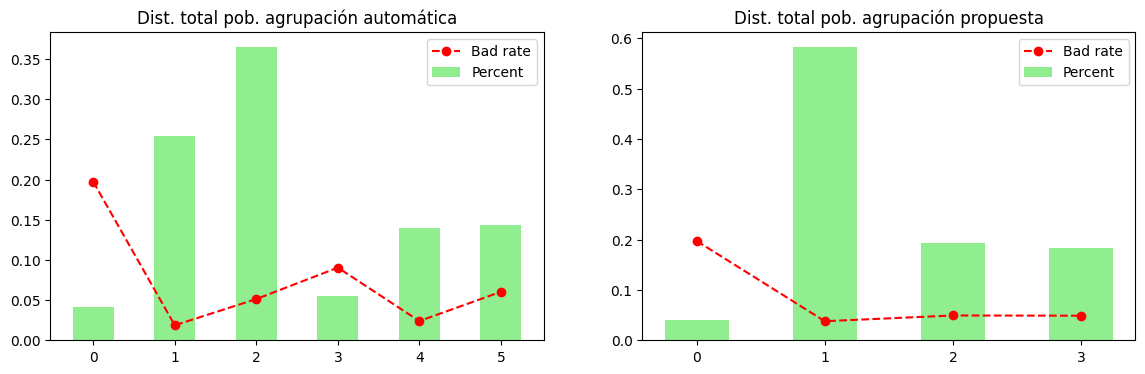

----------------------------------------------------------------------------------------------------
Agrupación automática: {'bp': [-12345670.0, 23.75, 30.75, 32.05, 36.45], 'mg': 0}
----------------------------------------------------------------------------------------------------
Agrupación final propuesta: {'bp': [-12345670.0, 30, 35], 'mg': 0}
----------------------------------------------------------------------------------------------------


In [15]:
me.reagrupa_var(X_train, y_train, autogroupings, 'bmi', {'bp': [-12345670.0, 30, 35], 'mg': 0}, dims=(14, 4))
# me.reagrupa_var(X_train, y_train, autogroupings, 'bmi', [-12345670.0, 30, 35]) # Es equivalente

<span style='color:blue'>Vamos a lanzar otra scorecard con esta última agrupación en el `bmi`. Dado que esta es peor que la automática debería salir una scorecard con menos Gini

In [16]:
modelo4 = me.Scorecard(
    features=['age', 'bmi', 'avg_glucose_level'],
    user_breakpoints={
        'age': [30, 60],
        'bmi': {'bp': [-12345670.0, 30, 35], 'mg': 0}
    }
).fit(X, y)

Particionado 70-30 estratificado en el target terminado
------------------------------------------------------------------------------------------------------------------------
Autogrouping terminado. Máximo número de buckets = 5. Mínimo porcentaje por bucket = 0.05
------------------------------------------------------------------------------------------------------------------------
Step 01 | 0:00:00.000000 | pv = 8.28e-27 | Gini train = 56.54% | Gini test = 54.72% ---> Feature selected: age
Step 02 | 0:00:00.000000 | pv = 2.80e-08 | Gini train = 59.96% | Gini test = 59.61% ---> Feature selected: bmi
Step 03 | 0:00:00.000000 | pv = 5.89e-07 | Gini train = 65.13% | Gini test = 61.32% ---> Feature selected: avg_glucose_level
------------------------------------------------------------------------------------------------------------------------
Selección terminada: ['age', 'bmi', 'avg_glucose_level']
---------------------------------------------------------------------------------------

<span style='color:blue'>Echamos un ojo a como quedaría la scorecard

In [17]:
me.pretty_scorecard(modelo4, 'red')

,Variable,Group,Count,Percent,Goods,Bads,Bad rate,WoE,IV,Raw score,Aligned score
0,age,"(-inf, 30.00)",1077,0.301090,1075,2,0.001857,3.313571,1.008663,-2.992993,282
1,age,"[30.00, 60.00)",1538,0.429969,1494,44,0.028609,0.551665,0.102693,-0.498293,210
2,age,"[60.00, inf)",962,0.268940,834,128,0.133056,-1.099154,0.539195,0.992814,167
3,bmi,Missing,147,0.041096,118,29,0.197279,-1.569969,0.207222,1.083642,164
4,bmi,"(-inf, 30.00)",2085,0.582891,2006,79,0.037890,0.261093,0.035367,-0.180214,201
5,bmi,"[30.00, 35.00)",690,0.192899,656,34,0.049275,-0.013557,0.000036,0.009358,195
6,bmi,"[35.00, inf)",655,0.183114,623,32,0.048855,-0.004547,0.000004,0.003138,195
7,avg_glucose_level,"(-inf, 72.72)",645,0.180319,624,21,0.032558,0.418271,0.026216,-0.230375,202
8,avg_glucose_level,"[72.72, 76.48)",201,0.056192,185,16,0.079602,-0.525590,0.019757,0.289484,187
9,avg_glucose_level,"[76.48, 165.21)",2278,0.636847,2205,73,0.032046,0.434666,0.099285,-0.239405,202


<span style='color:blue'>**Vamos ahora con las de tipo texto**. Reagrupar estas variables es muy sencillo: solo hay que pasarle una lista con las sublistas que queremos como nuevos grupos, y el missing se trata como una categoría más igual al resto 😊

<span style='color:blue'>Vamos a verlo con la variable `worktype` a la que metimos missings artificialmente

,Group,Count,Percent,Goods,Bads,Bad rate,WoE,IV
0,[Missing],572,0.159911,530,42,0.073427,-0.43815,0.037521
1,[Private],2025,0.566117,1915,110,0.054321,-0.116365,0.008081
2,[Govt_job],467,0.130556,447,20,0.042827,0.133469,0.002191
3,"[children, Never_worked]",513,0.143416,511,2,0.003899,2.569865,0.356356
Totals,,3577,1.000000,3403,174,0.048644,,0.404149
,Group,Count,Percent,Goods,Bads,Bad rate,WoE,IV
0,"[Private, Govt_job]",2492,0.696673,2362,130,0.052167,-0.073628,0.003905
1,"[Missing, Never_worked]",590,0.164943,548,42,0.071186,-0.404752,0.032520
2,[children],495,0.138384,493,2,0.004040,2.534005,0.337980
Totals,,3577,1.000000,3403,174,0.048644,,0.374405


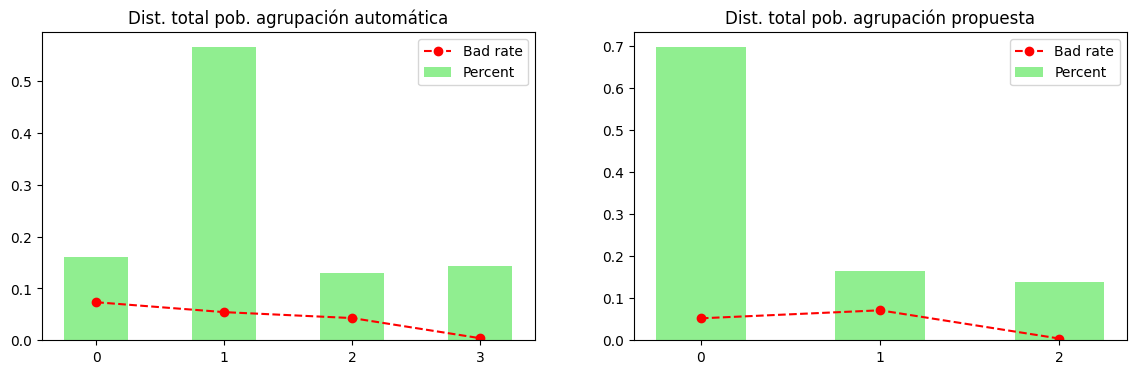

----------------------------------------------------------------------------------------------------
Agrupación automática: [['Missing'], ['Private'], ['Govt_job'], ['children', 'Never_worked']]
----------------------------------------------------------------------------------------------------
Agrupación final propuesta: [['Private', 'Govt_job'], ['Missing', 'Never_worked'], ['children']]
----------------------------------------------------------------------------------------------------


In [18]:
me.reagrupa_var(X_train, y_train, autogroupings, 'work_type',
[['Private', 'Govt_job'], ['Missing', 'Never_worked'], ['children']], dims=(14, 4))

<span style='color:blue'>Lanzamos la última scorecard con todas las reagrupaciones que hemos hecho

In [19]:
modelo6 = me.Scorecard(
    features=['age', 'bmi', 'avg_glucose_level', 'work_type'],
    user_breakpoints={
        'age': [30, 60],
        'bmi': {'bp': [-12345670.0, 30, 35], 'mg': 0},
        'work_type': [['Private', 'Govt_job'], ['Missing', 'Never_worked'], ['children']]
    }
).fit(X, y)

Particionado 70-30 estratificado en el target terminado
------------------------------------------------------------------------------------------------------------------------
Autogrouping terminado. Máximo número de buckets = 5. Mínimo porcentaje por bucket = 0.05
------------------------------------------------------------------------------------------------------------------------
Step 01 | 0:00:00.000000 | pv = 8.28e-27 | Gini train = 56.54% | Gini test = 54.72% ---> Feature selected: age
Step 02 | 0:00:00.000000 | pv = 2.80e-08 | Gini train = 59.96% | Gini test = 59.61% ---> Feature selected: bmi
Step 03 | 0:00:00.000000 | pv = 5.89e-07 | Gini train = 65.13% | Gini test = 61.32% ---> Feature selected: avg_glucose_level
Step 04 | 0:00:00.000000 | pv = 1.20e-01 | Gini train = 65.40% | Gini test = 60.83% ---> Feature selected: work_type
------------------------------------------------------------------------------------------------------------------------
Selección terminada: ['age'

In [20]:
me.pretty_scorecard(modelo6, 'orange')

,Variable,Group,Count,Percent,Goods,Bads,Bad rate,WoE,IV,Raw score,Aligned score
0,age,"(-inf, 30.00)",1077,0.301090,1075,2,0.001857,3.313571,1.008663,-3.217220,239
1,age,"[30.00, 60.00)",1538,0.429969,1494,44,0.028609,0.551665,0.102693,-0.535624,162
2,age,"[60.00, inf)",962,0.268940,834,128,0.133056,-1.099154,0.539195,1.067193,116
3,bmi,Missing,147,0.041096,118,29,0.197279,-1.569969,0.207222,1.091215,115
4,bmi,"(-inf, 30.00)",2085,0.582891,2006,79,0.037890,0.261093,0.035367,-0.181474,152
5,bmi,"[30.00, 35.00)",690,0.192899,656,34,0.049275,-0.013557,0.000036,0.009423,146
6,bmi,"[35.00, inf)",655,0.183114,623,32,0.048855,-0.004547,0.000004,0.003160,146
7,avg_glucose_level,"(-inf, 72.72)",645,0.180319,624,21,0.032558,0.418271,0.026216,-0.228297,153
8,avg_glucose_level,"[72.72, 76.48)",201,0.056192,185,16,0.079602,-0.525590,0.019757,0.286873,138
9,avg_glucose_level,"[76.48, 165.21)",2278,0.636847,2205,73,0.032046,0.434666,0.099285,-0.237245,153


<span style='color:red'>Vamos a echar un vistazo a la otra vía posible para sacar las reagrupaciones: **la interfaz gráfica**

<span style='color:blue'>Seleccionamos una lista de variables que queremos tener para poder reagrupar con la interfaz y es importante asegurarse de que tenemos el data del train y sus autogroupings definidos

In [21]:
X_train, y_train = me.split(X, y)[0:3:2]
autogroupings = me.autogrouping(X_train, y_train)[0]
variables_interfaz = ['age', 'bmi', 'work_type']

<span style='color:blue'>Hay que hacer una serie de importaciones y unos 'truquitos' para poder usarla. Lo malo es que con este apaño de redifinir en nuestro entono global perdemos los valores por defecto

In [22]:
# import types, ipywidgets as widgets, matplotlib.pyplot as plt, copy
# interfaz_grafica = types.FunctionType(me.interfaz_grafica.__code__, globals())
# color1, color2, color3, dims = 'lightgreen', 'lightgreen', 'aquamarine', (14, 4)
# interfaz_grafica(X_train, y_train, autogroupings, variables_interfaz, {'bmi': [25]}, color1, color2, color3, dims)

<span style=color:blue>Tras su ejecución su resultado es la variable global `agrupaciones_interfaz` que es un diccionario con las reagrupaciones manuales que se han ido haciendo

In [23]:
# print(agrupaciones_interfaz)

In [24]:
# modelo7 = me.Scorecard(
#     features=['age', 'bmi', 'avg_glucose_level', 'work_type'],
#     user_breakpoints=agrupaciones_interfaz
# ).fit(X, y)

In [25]:
# me.pretty_scorecard(modelo7, 'yellow')

<span style='color:blue'>Por último, al igual que la función `reagrupa_var`, aquí también podemos comparar contra agrupaciones que no sean las automáticas

In [26]:
# comparing_bp = {'age': {'bp': [30, 40], 'mg': None}}
# interfaz_grafica(X_train, y_train, autogroupings, ['age'],
# comparing_bp, color1, color2, color3, dims)

In [27]:
# print(agrupaciones_interfaz)